Tutorial: Field-maps
===============================
*01/2021: updated to pyGDM v1.1+*

This is an example how to calculate the electric and magnetic field *outside* the nano-structure.


In [1]:
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

import matplotlib.pyplot as plt

Simulation: Silicon nanowire
------------------------------

We will setup a simulation for a cuboidal silicon nanowire, evaluated at a single wavelength and linear polarization. For the polarization angle we will use an angle somewhat off the nanowire long axis:

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 600/600 dipoles valid
N dipoles: 600


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


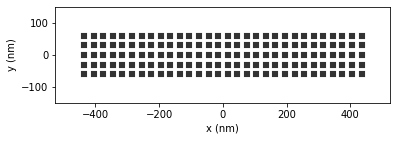

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=600.00nm - setup: EE 10720.7ms, inv.: 282.5ms, repropa.: 8047.2ms (1 field configs), tot: 19050.8ms


In [2]:
## ---------- Setup structure
mesh = 'cube'
step = 30.0
geometry = structures.rect_wire(step, L=30,H=4,W=5, mesh='cube')
geometry = structures.center_struct(geometry)
material = materials.silicon()

struct = structures.struct(step, geometry, material)


## ---------- Setup incident field
field_generator = fields.plane_wave
kwargs = dict(theta = [30.0])  ## by default: incidence from top
wavelengths = [600]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## ---------- vacuum environment
n1 = n2 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## ---------- Simulation initialization
sim = core.simulation(struct, efield, dyads)

print("N dipoles:", len(sim.struct.geometry))
visu.structure(geometry, scale=0.7)

#==============================================================================
# run the simulation: possible either via sim.scatter() or via core.scatter(sim)
#==============================================================================
E = core.scatter(sim)

OK, now we need to
calculate field-maps outside the structure
--------------------------------------------------

We will do several field-maps at increasing *distances* from the nanowire and compare those.

In [3]:
#==============================================================================
# Nearfield map below structure
#==============================================================================
distances = [-1*step, -3*step, -5*step, -7*step]

Es = []
Bs = []
Etot = []
Btot = []
for Z0 in distances:
    r_probe = tools.generate_NF_map_XY(-500,500,51, -500,500,51, Z0=Z0)
    
    ## --- linear.nearfield takes either a whole "map" or only a
    ## --- 3D coordinate as input. Here we want the field on a map.
    _Es, _Etot, _Bs, _Btot = linear.nearfield(sim, field_index=0, r_probe=r_probe)
    Es.append(_Es)
    Etot.append(_Etot)
    Bs.append(_Bs)
    Btot.append(_Btot)

Using the **visu** module, we plot the fields as 2D vector representation as well as the field-intensity as colorplot.

Scattered electric field
-------------------------

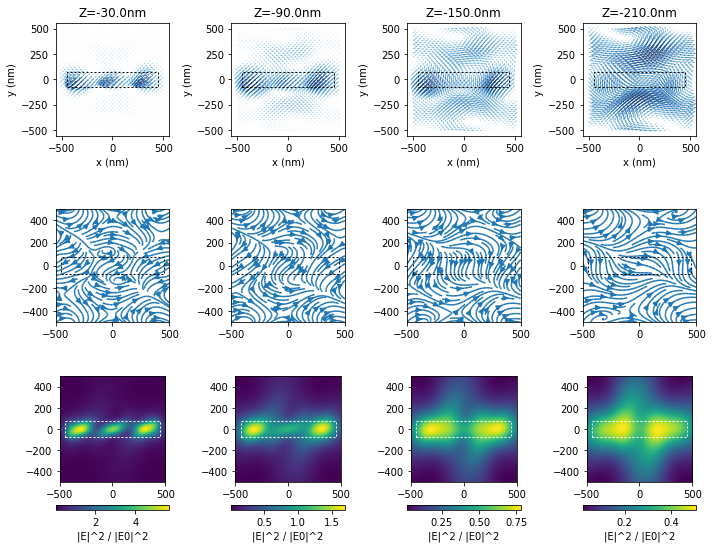

In [4]:
## --- limit the number of ticks on the axes (for the colorbar!)
from matplotlib.ticker import MaxNLocator
MaxNLocator.default_params['nbins'] = 4

## the plot
plt.figure(figsize=(10, 8))

for i, _Es in enumerate(Es):
    ## --- field vectors
    plt.subplot(3,len(Es),1+i, aspect='equal')
    plt.title("Z={}nm".format(distances[i]))
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield(_Es, show=0, EACHN=2)
    
    ## --- field isolines
    plt.subplot(3,len(Es),1+1*len(Es)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield_fieldlines(_Es, show=0)

    ## --- field intensity
    plt.subplot(3,len(Es),1+2*len(Es)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='w', show=0)
    im = visu.vectorfield_color(_Es, show=0)
    plt.colorbar(im, orientation='horizontal', label="|E|^2 / |E0|^2")

plt.tight_layout()
plt.show()

Scattered magnetic field
-------------------------

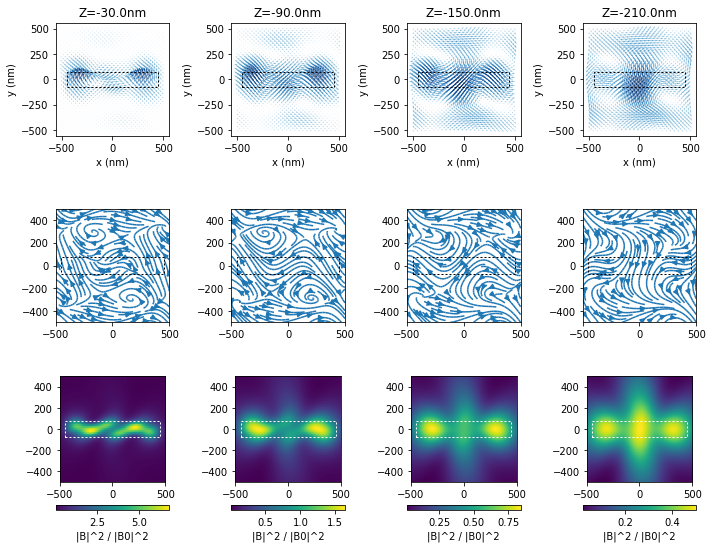

In [5]:
plt.figure(figsize=(10, 8))

for i, _Bs in enumerate(Bs):
    ## --- field vectors
    plt.subplot(3,len(Bs),1+i, aspect='equal')
    plt.title("Z={}nm".format(distances[i]))
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield(_Bs, show=0, EACHN=2)
    
    ## --- field isolines
    plt.subplot(3,len(Bs),1+1*len(Bs)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='k', show=0)
    visu.vectorfield_fieldlines(_Bs, show=0)

    ## --- field intensity
    plt.subplot(3,len(Bs),1+2*len(Bs)+i, aspect='equal')
    visu.structure_contour(sim, zorder=10, dashes=[2,2], color='w', show=0)
    im = visu.vectorfield_color(_Bs, show=0)
    plt.colorbar(im, orientation='horizontal', label="|B|^2 / |B0|^2")

plt.tight_layout()
plt.show()